# Check Inference on Synthetic Observations

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os

import h5py
import numpy as np
import matplotlib.pyplot as plt
from prospect.utils.obsutils import fix_obs

from agnfinder.prospector import visualise, main, cpz_builders

In [3]:
os.chdir('/home/mike/repos/agnfinder')

In [4]:
!pwd

/home/mike/repos/agnfinder


In [5]:
galaxy_index = 1
galaxy = main.load_galaxy(galaxy_index)
redshift = galaxy['redshift']

In [6]:
agn_mass = True
agn_eb_v = True
obscured_torus = True
igm_absorbtion = True

In [7]:
run_params, obs, model, sps = main.construct_problem(galaxy, redshift=redshift, agn_mass=agn_mass, agn_eb_v=agn_eb_v, obscured_torus=obscured_torus, igm_absorbtion=igm_absorbtion)

sps should be an instance of my custom CSPSpecBasisAGN class

In [8]:
sps

And model should include agn_mass and agn_eb_v

In [9]:
model.free_params

['mass',
 'dust2',
 'tage',
 'tau',
 'agn_mass',
 'agn_eb_v',
 'obscured_torus',
 'agn_torus_mass']

In [10]:
model.fixed_params

['zred',
 'logzsol',
 'sfh',
 'imf_type',
 'dust_type',
 'add_dust_emission',
 'duste_umin',
 'duste_qpah',
 'duste_gamma',
 'add_igm_absorption',
 'igm_factor']

In [11]:
model_spectrum, model_photometry, _ = model.sed(model.theta, obs, sps)  # trigger fsps calculation, takes a couple of minutes - then cached

[1.95904139 1.97312785 1.98227123 ... 7.99197879 7.995986   8.        ] log wavelengths


In [12]:
model_photometry

array([1.92950933e-08, 1.45156349e-08, 2.41722870e-08, 4.81060849e-08,
       6.70393237e-08, 7.74241159e-08, 1.00972735e-07, 4.20310840e-07,
       2.17479509e-07, 8.63780646e-07, 1.34658006e-07, 9.96709586e-08,
       1.58356809e-06, 1.57680791e-06])

In [13]:
sps.quasar_flux

array([2.85818808e-31, 3.00416790e-31, 3.10465344e-31, ...,
       5.65752351e-28, 5.65752351e-28, 5.65752351e-28])

In [14]:
assert max(sps.quasar_flux) > min(sps.quasar_flux)  # quasar component should be SOMETHING

## How does the SED change as we vary the AGN parameters?

In [15]:
model_param_index = dict(zip(model.free_params, range(len(model.free_params))))

In [16]:
theta_no_agn = model.theta.copy()
theta_agn = model.theta.copy()

# unobscured agn
theta_agn[model_param_index['agn_mass']] = 1e15
theta_agn[model_param_index['agn_torus_mass']] = 0
theta_no_agn[model_param_index['agn_mass']] = 0
theta_no_agn[model_param_index['agn_torus_mass']] = 0


[1.95904139 1.97312785 1.98227123 ... 7.99197879 7.995986   8.        ] log wavelengths
[1.95904139 1.97312785 1.98227123 ... 7.99197879 7.995986   8.        ] log wavelengths


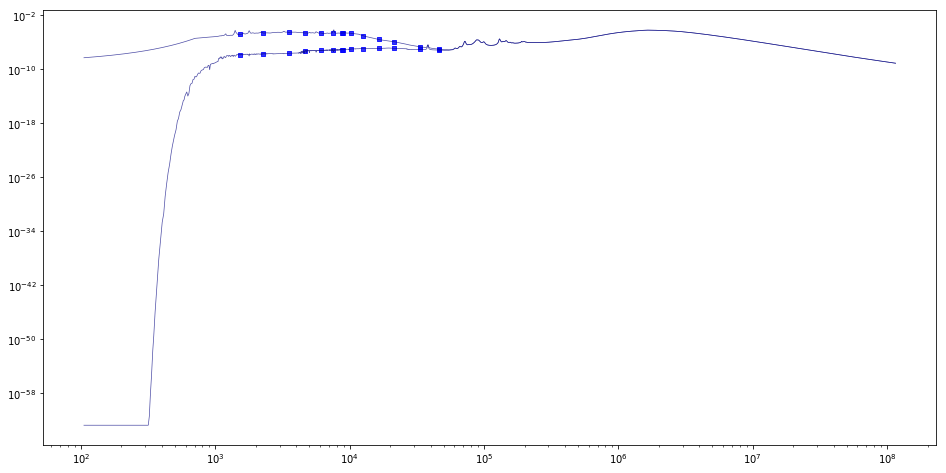

In [17]:
fig, ax = plt.subplots(figsize=(16, 8))
visualise.plot_model_at_obs(ax, model, theta_no_agn, obs, sps)  # no torus, so looks weirdly blue-only
visualise.plot_model_at_obs(ax, model, theta_agn, obs, sps)  
# plt.loglog(sps.wavelengths, sps.galaxy_flux, label='Galaxy')

In [18]:
observer_wavelengths = visualise.get_observer_frame_wavelengths(model, sps)

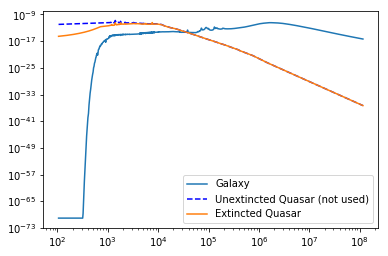

In [19]:
plt.loglog(observer_wavelengths, sps.galaxy_flux, label='Galaxy')
plt.loglog(observer_wavelengths, sps.unextincted_quasar_flux, 'b--', label='Unextincted Quasar (not used)')
plt.loglog(observer_wavelengths, sps.extincted_quasar_flux, label='Extincted Quasar')
# plt.loglog(observer_wavelengths, sps.torus_flux, label='Torus')
# plt.loglog(observer_wavelengths, sps.quasar_flux, 'k', label='Net (Quasar)')
plt.legend()

What if we add extinction?

In [20]:
theta_agn_extinction = theta_agn.copy()
theta_agn_no_extinction = theta_agn.copy()

theta_agn_extinction[model_param_index['agn_eb_v']] = 0.5
theta_agn_no_extinction[model_param_index['agn_eb_v']] = 0

[1.95904139 1.97312785 1.98227123 ... 7.99197879 7.995986   8.        ] log wavelengths
[1.95904139 1.97312785 1.98227123 ... 7.99197879 7.995986   8.        ] log wavelengths


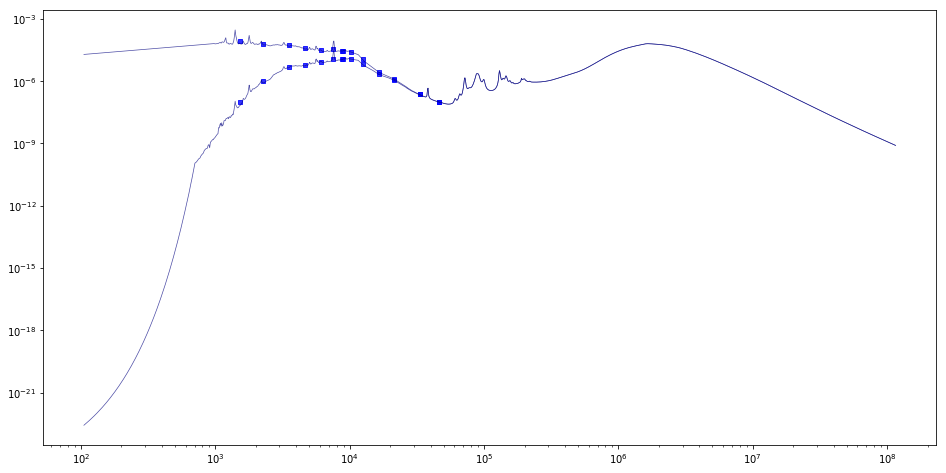

In [21]:
fig, ax = plt.subplots(figsize=(16, 8))
visualise.plot_model_at_obs(ax, model, theta_agn_extinction, obs, sps)  
visualise.plot_model_at_obs(ax, model, theta_agn_no_extinction, obs, sps)  # exactly as with AGN above

What about with the AGN + Torus?

In [22]:
theta_agn_extinction_torus = theta_agn_extinction.copy()
theta_agn_extinction_no_torus = theta_agn_extinction.copy()

theta_agn_extinction_torus[model_param_index['agn_torus_mass']] = 1.
theta_agn_extinction_no_torus[model_param_index['agn_torus_mass']] = 0.

[1.95904139 1.97312785 1.98227123 ... 7.99197879 7.995986   8.        ] log wavelengths


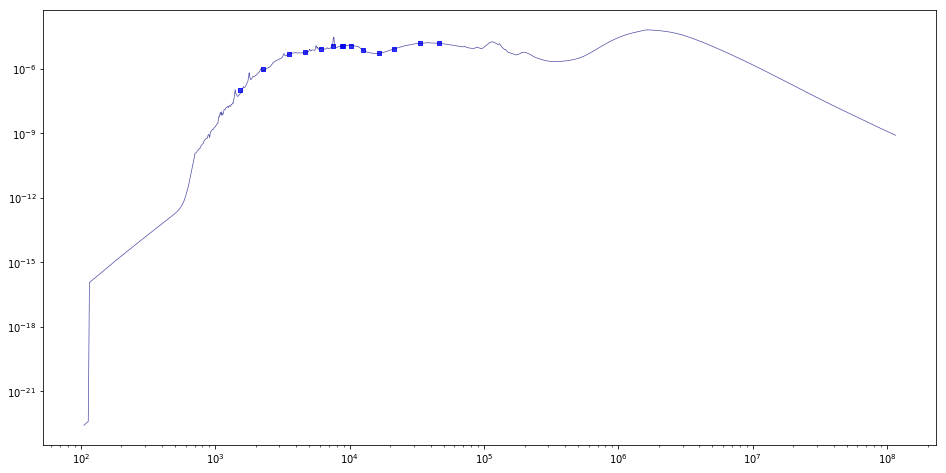

In [23]:
fig, ax = plt.subplots(figsize=(16, 8))
# visualise.plot_model_at_obs(ax, model, theta_agn_extinction_no_torus, obs, sps)  
visualise.plot_model_at_obs(ax, model, theta_agn_extinction_torus, obs, sps)

<Figure size 432x288 with 0 Axes>

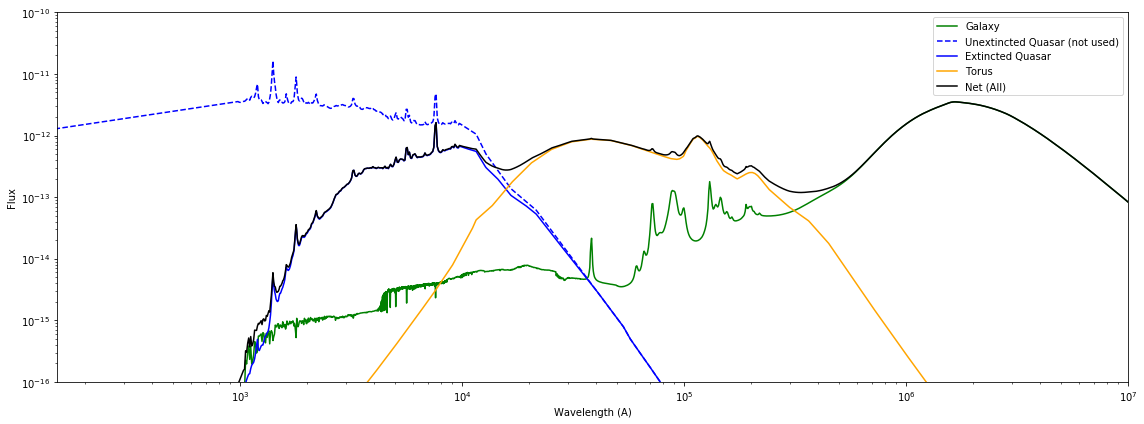

In [36]:
plt.clf()
fig, ax = plt.subplots(figsize=(16, 6))
ax.loglog(observer_wavelengths, sps.galaxy_flux, 'g', label='Galaxy')
ax.loglog(observer_wavelengths, sps.unextincted_quasar_flux, 'b--', label='Unextincted Quasar (not used)')
ax.loglog(observer_wavelengths, sps.extincted_quasar_flux, 'b', label='Extincted Quasar')
ax.loglog(observer_wavelengths, sps.torus_flux, 'orange', label='Torus')
# ax.loglog(observer_wavelengths, sps.quasar_flux, 'k--', label='Net (Quasar)')
ax.loglog(observer_wavelengths, sps.quasar_flux + sps.galaxy_flux, 'k', label='Net (All)')
ax.legend()
ax.set_ylim([1e-16, 1e-10])
ax.set_xlim(1.5e2, 1e7)
ax.set_ylabel('Flux')
ax.set_xlabel('Wavelength (A)')
fig.tight_layout()

In [25]:
theta_agn[model_param_index['mass']]

10000000000.0

## Can we recover the original parameters?

In [26]:
assert False

AssertionError: 

In [ ]:
theta_to_recover = theta_agn_extinction

In [ ]:
model_spectrum, model_photometry, _ = model.sed(theta_to_recover, obs, sps)  # trigger fsps calculation, takes a couple of minutes - then cached

In [ ]:
def make_synthetic_obs_from_model(real_obs, maggies, snr=10.):
    synthetic_obs = {}
    synthetic_obs["filters"] =  real_obs['filters']
    synthetic_obs["maggies"] = maggies
    synthetic_obs['maggies_unc'] = maggies / snr

    synthetic_obs["phot_mask"] = np.array([True for _ in synthetic_obs['filters']])
    synthetic_obs["phot_wave"] = np.array([f.wave_effective for f in synthetic_obs["filters"]])
    synthetic_obs["wavelength"] = None
    synthetic_obs["spectrum"] = None
    synthetic_obs['unc'] = None
    synthetic_obs['mask'] = None
    synthetic_obs = fix_obs(synthetic_obs)
    return synthetic_obs


In [ ]:
synthetic_obs = make_synthetic_obs_from_model(obs, model_photometry)

### Max Likelihood (starting from correct values, so unhelpful!)

In [ ]:
# theta_best, time_elapsed = main.fit_galaxy(run_params, synthetic_obs, model, sps)

### MCMC

In [ ]:
samples, mcmc_time_elapsed = main.mcmc_galaxy(run_params, synthetic_obs, model, sps, initial_theta=None, test=False)

In [ ]:
synthetic_obs = build_synthetic_obs_from_model(obs, model_photometry, snr=10.)

In [ ]:
visualise.visualise_obs(synthetic_obs)

In [ ]:
name = 'inference_to_recover_theta'
output_dir = '/home/mike/repos/agnfinder/results'

In [ ]:
sample_loc = os.path.join(output_dir, '{}_mcmc_samples.h5py'.format(name))
main.save_samples(samples, model, sample_loc)
corner_loc = os.path.join(output_dir, '{}_mcmc_corner.png'.format(name))
main.save_corner(samples[int(len(samples)/2):], model, corner_loc)  # nested sampling has no burn-in phase, early samples are bad

In [ ]:
theta_to_recover

In [ ]:
import corner

In [ ]:
for index in range(len(theta_to_recover)):
    print('Name: {}'.format(model.free_params[index]))
    print('True value: {:3.1E}'.format(theta_to_recover[index]))
    low, med, up = corner.quantile(samples[:, index], [.1, .5, .9])
    print('Estimate: {:3.1E} (min {:3.2E}, max {:3.3E})'.format(low, med, up))
    print('\n')
    

In [ ]:
traces_loc = os.path.join(output_dir, '{}_mcmc_traces.png'.format(name))
main.save_sed_traces(samples[-2000:], synthetic_obs, model, sps, traces_loc)


In [ ]:
plt.loglog(sps.wavelengths, sps.extincted_quasar_flux)
_, spectra, _ = sps.get_galaxy_spectrum()
plt.loglog(sps.wavelengths, spectra)

In [ ]:
len(sps.wavelengths)

In [ ]:
sps.extincted_quasar_flux.sum() / model_spectrum.sum()

In [ ]:
len(sps.extincted_quasar_flux)

In [ ]:
len(model_spectrum)